In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from rdkit import Chem
import numpy as np
import os
import sys
sys.path.append('../')
sys.path.append('../data_processing/')

from openbabel import pybel
import matplotlib
import matplotlib.pylab as plt
import matplotlib.cm as cm
from matplotlib.colors import Normalize
import random
import torch
from sklearn.cluster import DBSCAN, HDBSCAN

In [3]:
from data_processing.ligand import Ligand
from data_processing.utils import sample_probability
from data_processing.utils import ATOM_TYPE_MAPPING, PP_TYPE_MAPPING, ATOM_FAMILIES, MAP_ATOM_TYPE_AROMATIC_TO_INDEX
from evaluation.utils_eval import build_pdb_dict

In [4]:
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Draw
from rdkit.Chem.Draw import rdMolDraw2D
from IPython.display import SVG, Image
IPythonConsole.drawOptions.addAtomIndices = True
IPythonConsole.ipython_useSVG = True
IPythonConsole.molSize = 600, 300

In [5]:
root = '/home/conghao001/pharmacophore2drug/PP2Drug/data/cleaned_crossdocked_data/raw'
pdb_dict, pdb_rev_dict = build_pdb_dict(root)

In [6]:
ligand_fn = '2ilt_A_rec_3ey4_352_lig_tt_min_0.sdf'
path = os.path.join(root, pdb_rev_dict[ligand_fn], ligand_fn)

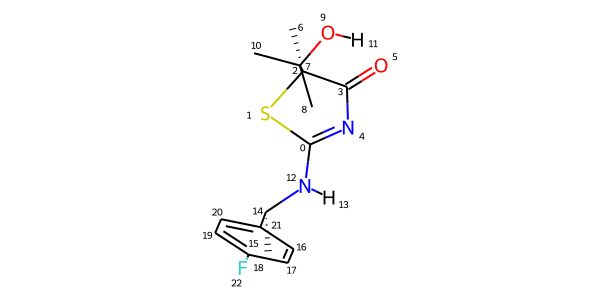

In [7]:
# path = '../../data/small_dataset/raw/ZAP70_HUMAN_327_607_0/2ozo_A_rec_2ozo_anp_lig_tt_docked_2.sdf'
rdmol = Chem.MolFromMolFile(path, removeHs=False, sanitize=True)
rdmol

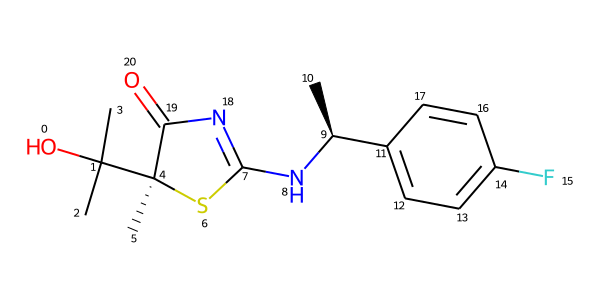

In [8]:
mol = Chem.MolFromSmiles(Chem.MolToSmiles(rdmol))
mol

In [9]:
print(len(rdmol.GetAtoms()), len(mol.GetAtoms()))

23 21


- atomic number becomes different -> don't use this mol to show pp/cluster

In [10]:
len(rdmol.GetConformers())

1

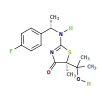

In [11]:
pbmol = next(pybel.readfile("sdf", path))
pbmol

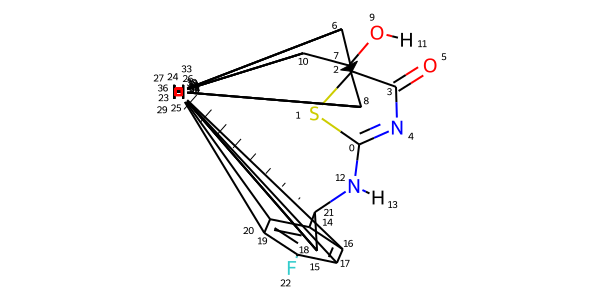

In [12]:
# not normal at all?????

rdmol = Chem.AddHs(rdmol)
rdmol

In [13]:
len(rdmol.GetAtoms())

40

In [14]:
ligand = Ligand(pbmol, rdmol, atom_positions=None, conformer_axis=None, filtering=False)
# ligand_full = Ligand(pbmol, rdmol, atom_positions=None, conformer_axis=None, filtering=False)
len(ligand.graph.node_clusters)

9

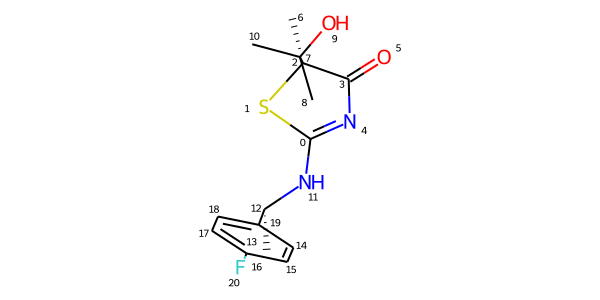

In [15]:
rdmol = ligand.rdmol_noH
rdmol

In [16]:
for atom in rdmol.GetAtoms():
    print(atom.GetSymbol())

C
S
C
C
N
O
C
C
C
O
C
N
C
C
C
C
C
C
C
C
F


In [16]:
len(rdmol.GetAtoms())

21

In [17]:
n_atom = 0
n = 0
for cluster in ligand.graph.node_clusters:
    print(len(cluster.nodes))
    n += cluster.positions.shape[1]
    for node in cluster.nodes:
        atom_idx = node.atom_indices
        print(atom_idx)
        n_atom += len(atom_idx)
print('total number of atoms involved in at least one cluster:', n_atom)  # there are overlappings
print('total number of pp nodes in all clusters:', n)

1
{14, 15, 16, 17, 18, 19}
1
{20}
1
{6}
2
{8}
{10}
1
{13}
1
{9}
1
{11}
1
{4}
1
{5}
total number of atoms involved in at least one cluster: 15
total number of pp nodes in all clusters: 10


- Overlapping problem: some atoms exist in multiple pp/clusters

In [18]:
atom_indice_list = []

for node in ligand.graph.nodes:
    print(node.positions.squeeze())
    print(node.types, node.index)
    atom_indices = list([node.atom_indices]) if type(node.atom_indices)==int else list(sorted(node.atom_indices))
    print(atom_indices)
    atom_indice_list.append(atom_indices)
    
atom_indice_list

[ 3.8480167 -4.597417  14.454633 ]
['Aromatic'] 0
[14, 15, 16, 17, 18, 19]
[ 5.0273  1.933  12.6781]
['Hydrophobic'] 1
[6]
[ 5.6245 -0.4679 15.6828]
['Hydrophobic'] 2
[8]
[ 3.8356  1.1903 15.3684]
['Hydrophobic'] 3
[10]
[ 4.2649 -4.8963 10.7759]
['Hydrophobic'] 4
[13]
[ 6.1138  1.8271 15.3628]
['HBond_donor'] 5
[9]
[ 5.405  -2.902  11.5728]
['HBond_donor'] 6
[11]
[ 6.7338 -1.1023 12.3233]
['HBond_acceptor'] 7
[4]
[ 7.7515  0.8165 13.1724]
['HBond_acceptor'] 8
[5]
[ 3.4924 -5.4275 17.0554]
['Halogen'] 9
[20]


[[14, 15, 16, 17, 18, 19], [6], [8], [10], [13], [9], [11], [4], [5], [20]]

In [19]:
ligand.atom_positions.squeeze().shape

(21, 3)

In [20]:
ligand.num_atoms

21

In [21]:
# direct get positions from conformer will include Hs
conformer = rdmol.GetConformer()
conformer.GetPositions().shape

(21, 3)

In [22]:
all_pp = []
for i, (pp_type, pp_node) in enumerate(ligand.pharmacophore_list):
    atom_indices = tuple([pp_node.atom_indices]) if type(pp_node.atom_indices)==int else tuple(sorted(pp_node.atom_indices))
#     print(pp_type, atom_indices)
    all_pp.append([pp_type, atom_indices, i])
    

all_pp

[['Aromatic', (14, 15, 16, 17, 18, 19), 0],
 ['Hydrophobic', (6,), 1],
 ['Hydrophobic', (8,), 2],
 ['Hydrophobic', (10,), 3],
 ['Hydrophobic', (13,), 4],
 ['HBond_donor', (9,), 5],
 ['HBond_donor', (11,), 6],
 ['HBond_acceptor', (4,), 7],
 ['HBond_acceptor', (5,), 8],
 ['Halogen', (20,), 9]]

In [23]:
# already added to the ligand class

# def remove_overlapping_pp(pp_list):
#     # Sort clusters by size in descending order
#     pp_list.sort(key=lambda x:len(x[1]), reverse=True)

#     unique_nodes = set()
#     non_overlapping_pp = []

#     for pp in pp_list:
#         # If cluster nodes are not in unique_nodes, add them
#         if not any(node in unique_nodes for node in pp[1]):
#             unique_nodes.update(pp[1])
#             non_overlapping_pp.append(pp)

#     return non_overlapping_pp

In [24]:
# pp_list = remove_overlapping_pp(all_pp)
# pp_list

In [25]:
one_hot_encoding = {'H': 0, 'C': 1, 'N': 2, 'O': 3, 'F': 4, 'P': 5, 'S': 6, 'Cl': 7}    # 8 classes
one_hot_x = [one_hot_encoding[atom.GetSymbol()] for atom in rdmol.GetAtoms()]
one_hot_x

[1, 6, 1, 1, 2, 3, 1, 1, 1, 3, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 4]

In [26]:
one_hot_x_tensor = torch.tensor(one_hot_x, dtype=torch.long)
one_hot_x_tensor = torch.nn.functional.one_hot(one_hot_x_tensor, num_classes=len(one_hot_encoding.keys())).to(torch.float)
one_hot_x_tensor

tensor([[0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0.]])

In [27]:
# random.seed(2024)
# random.shuffle(all_pp)
# num = [3, 4, 5, 6, 7]
# num_p = [0.086, 0.0864, 0.389, 0.495, 0.0273]  # P(Number of Pharmacophore points)
# num_ = sample_probability(num, num_p, 1)
# num_

In [28]:
# type_list = []
# size_ = []

# ## The randomly generated clusters are obtained,
# # and the next step is to perform a preliminary merging of these randomly generated clusters with identical elements
# if len(all_pp) >= int(num_[0]):
#     mol_phco = all_pp[:int(num_[0])]
# else:
#     mol_phco = all_pp

# for pharmocophore_all_i in range(len(mol_phco)):
#     for pharmocophore_all_j in range(len(mol_phco)):
#         if mol_phco[pharmocophore_all_i][1] == mol_phco[pharmocophore_all_j][1] \
#                 and mol_phco[pharmocophore_all_i][0] != mol_phco[pharmocophore_all_j][0]:
#             index_ = [min(mol_phco[pharmocophore_all_i][0], mol_phco[pharmocophore_all_j][0]),
#                       max(mol_phco[pharmocophore_all_i][0], mol_phco[pharmocophore_all_j][0])]
#             mol_phco[pharmocophore_all_j] = [index_, mol_phco[pharmocophore_all_i][1], mol_phco[pharmocophore_all_i][2]]
#             mol_phco[pharmocophore_all_i] = [index_, mol_phco[pharmocophore_all_i][1], mol_phco[pharmocophore_all_i][2]]
#         else:
#             index_ = mol_phco[pharmocophore_all_i][0]

In [29]:
# mol_phco

In [30]:
# unique_index_filter = []
# unique_index = []
# for mol_phco_candidate_single in mol_phco:
#     if mol_phco_candidate_single not in unique_index:
#         if type(mol_phco[0]) == list:
#             unique_index.append(mol_phco_candidate_single)
#         else:
#             unique_index.append([[mol_phco_candidate_single[0]], mol_phco_candidate_single[1]], mol_phco[pharmocophore_all_i][2])
# for unique_index_single in unique_index:
#     if unique_index_single not in unique_index_filter:
#         unique_index_filter.append(unique_index_single)

In [31]:
# unique_index_filter

In [32]:
# ## The following is the order of the pharmacophores by atomic number
# sort_index_list = []
# for unique_index_filter_i in unique_index_filter:  ## Collect the mean of the participating elements
#     sort_index = sum(unique_index_filter_i[1]) / len(unique_index_filter_i[1])
#     sort_index_list.append(sort_index)
# sorted_id = sorted(range(len(sort_index_list)), key=lambda k: sort_index_list[k])
# unique_index_filter_sort = []
# for index_id in sorted_id:
#     unique_index_filter_sort.append(unique_index_filter[index_id])

In [33]:
# unique_index_filter_sort

In [34]:
# new_pp_list = []
# for item in unique_index_filter_sort:
#     idx = item[2]
#     new_pp_list.append(ligand.pharmacophore_list[idx])
# new_pp_list

In [35]:
def group_by(mol, ligand, level='pp'):
    my_cmap = matplotlib.colormaps['coolwarm']
#     my_cmap = cm.get_cmap('coolwarm')
    if level == 'cluster':
        n_group = len(ligand.graph.node_clusters)
    elif level == 'pp':
        n = 0
        for cluster in ligand.graph.node_clusters:
            n += cluster.positions.shape[1]
        n_group = n
        pp_id = 0
        
    my_norm = Normalize(vmin=0, vmax=n_group)
    atommap, bondmap = {}, {}
    for i in range(len(ligand.graph.node_clusters)):
        cluster = ligand.graph.node_clusters[i]
        for node in cluster.nodes:
#             node = cluster.nodes[pp_id]
            atom_idx = node.atom_indices
            if level == 'cluster':
                for atom_id in atom_idx:
                    atom = mol.GetAtoms()[atom_id]
                    atom.SetProp("atomNote", str(i))
                atommap.update({atom_id:my_cmap(my_norm(i))[:3] for atom_id in atom_idx})
            elif level == 'pp':
                for atom_id in atom_idx:
                    atom = mol.GetAtoms()[atom_id]
                    atom.SetProp("atomNote", str(pp_id))
                atommap.update({atom_id:my_cmap(my_norm(pp_id))[:3] for atom_id in atom_idx})
                pp_id += 1
                
    highlights = {
        "highlightAtoms": list(atommap.keys()),
        "highlightAtomColors": atommap,
        "highlightBonds": list(bondmap.keys()),
        "highlightBondColors": bondmap,
    }
    mol_ = rdMolDraw2D.PrepareMolForDrawing(mol)
    imgsize = (600, 300)
    drawer = rdMolDraw2D.MolDraw2DSVG(*imgsize)
    drawer.DrawMolecule(mol_, **highlights)
    drawer.FinishDrawing()
    svg = drawer.GetDrawingText()
    display(SVG(svg.replace('svg:','')))

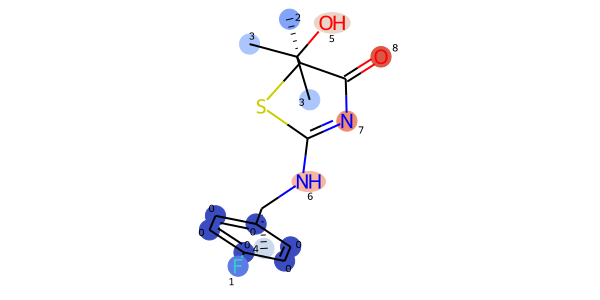

In [36]:
group_by(rdmol, ligand, 'cluster')

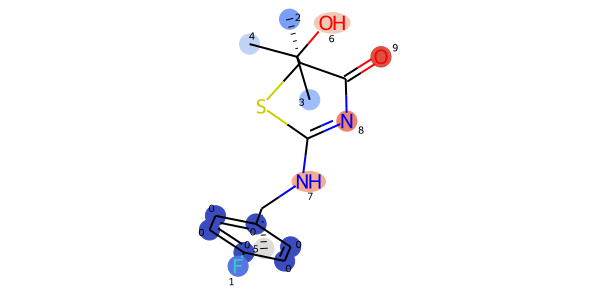

In [37]:
group_by(rdmol, ligand, 'pp')

In [38]:
# the atom ids in mol and rdmol are different, so don't run this
# group_by(mol, ligand, 'pp')

In [39]:
# group_by(rdmol, ligand_full, 'pp')

# Observations
- the atoms not inside any pharmacophores: can we consider them some linkage group between any two pps?
- how about the ones outside
- distances are of different scale in different mols. hard threshould may not be rational. **always rmb this!**

## Option 1: Build the group outside pharmacophores manully
- center group (similar dist to all pharmacophores)
- linkage group between pharmacophores 
    - 0: between pp 0 and 1; 1: 1-2; ...; -1: -1:0
- peripheral group (either outside one pharmacophore, or too distant from all pharmacophores):
    - closer to one pp, distant to the others

> related with the pps, but many cases to consider

## Option 2: DBSCAN based clustering methods
> directly cluster according to the non-pp nodes positions, regardless of pp nodes

In [40]:
def extract_pp(ligand, num_class):
    pp_type_mapping = PP_TYPE_MAPPING

    atom_indice_list = []
    position_list = []
    pp_type_list = []
    pp_index_list = []
    
    for pp_node in ligand.graph.nodes:
        atom_indices = list([pp_node.atom_indices]) if type(pp_node.atom_indices)==int else list(sorted(pp_node.atom_indices))
        positions = pp_node.positions.squeeze()
        index = pp_node.index
        # types = [one_hot_encoding[type] for type in pp_node.types]
        types = pp_type_mapping[pp_node.types[0]]  # we can't have multiple types for one pharmacophore, so we just take the first one

        atom_indice_list.append(atom_indices)
        position_list.append(positions)
        pp_index_list.append(index)
        pp_type_list.append(types)

    # atom_indices_tensor = torch.tensor(atom_indice_list, dtype=torch.long)
    positions_tensor = torch.tensor(np.array(position_list), dtype=torch.float)
    # one_hot_pp_tensor = torch.nn.functional.one_hot(torch.tensor(pp_type_list, dtype=torch.long), num_classes=len(pp_type_mapping.keys())).to(torch.float)
    one_hot_pp_tensor = torch.nn.functional.one_hot(torch.tensor(np.array(pp_type_list), dtype=torch.long), num_classes=num_class).to(torch.float)
    pp_index_tensor = torch.tensor(np.array(pp_index_list), dtype=torch.long)

    return atom_indice_list, positions_tensor, one_hot_pp_tensor, pp_index_tensor

In [41]:
num_feat_class = max(len(PP_TYPE_MAPPING.keys()), len(MAP_ATOM_TYPE_AROMATIC_TO_INDEX.keys()))
pp_atom_indices, pp_positions, pp_types, pp_index = extract_pp(ligand, num_feat_class)

In [42]:
atom_in_pp = []
for atom_indices in pp_atom_indices:
    atom_in_pp += atom_indices

atom_in_pp

[14, 15, 16, 17, 18, 19, 6, 8, 10, 13, 9, 11, 4, 5, 20]

In [43]:
print(ligand.atom_positions, pp_positions)

[[[ 5.5645 -1.6218 12.1868]]

 [[ 4.1789 -0.6595 12.8075]]

 [[ 5.3432  0.6305 13.4045]]

 [[ 6.6981  0.1537 12.975 ]]

 [[ 6.7338 -1.1023 12.3233]]

 [[ 7.7515  0.8165 13.1724]]

 [[ 5.0273  1.933  12.6781]]

 [[ 5.2486  0.8118 14.9472]]

 [[ 5.6245 -0.4679 15.6828]]

 [[ 6.1138  1.8271 15.3628]]

 [[ 3.8356  1.1903 15.3684]]

 [[ 5.405  -2.902  11.5728]]

 [[ 4.1991 -3.7073 11.7158]]

 [[ 4.2649 -4.8963 10.7759]]

 [[ 5.0574 -4.8508 13.8007]]

 [[ 4.8764 -5.2728 15.1208]]

 [[ 3.6677 -5.0192 15.776 ]]

 [[ 2.6388 -4.3469 15.1101]]

 [[ 2.819  -3.9246 13.7895]]

 [[ 4.0288 -4.1702 13.1307]]

 [[ 3.4924 -5.4275 17.0554]]] tensor([[ 3.8480, -4.5974, 14.4546],
        [ 5.0273,  1.9330, 12.6781],
        [ 5.6245, -0.4679, 15.6828],
        [ 3.8356,  1.1903, 15.3684],
        [ 4.2649, -4.8963, 10.7759],
        [ 6.1138,  1.8271, 15.3628],
        [ 5.4050, -2.9020, 11.5728],
        [ 6.7338, -1.1023, 12.3233],
        [ 7.7515,  0.8165, 13.1724],
        [ 3.4924, -5.4275, 17.0554]])

In [44]:
len(ligand.atom_positions)

21

In [45]:
atom_positions = ligand.atom_positions
num_atom = len(ligand.atom_positions)
num_pp = len(pp_positions)

num_atom, num_pp

(21, 10)

In [46]:
len(atom_in_pp), atom_in_pp

(15, [14, 15, 16, 17, 18, 19, 6, 8, 10, 13, 9, 11, 4, 5, 20])

In [47]:
atom_pos_dict = {i: pos for i, pos in enumerate(atom_positions)}
atom_pos_dict

{0: array([[ 5.5645, -1.6218, 12.1868]], dtype=float32),
 1: array([[ 4.1789, -0.6595, 12.8075]], dtype=float32),
 2: array([[ 5.3432,  0.6305, 13.4045]], dtype=float32),
 3: array([[ 6.6981,  0.1537, 12.975 ]], dtype=float32),
 4: array([[ 6.7338, -1.1023, 12.3233]], dtype=float32),
 5: array([[ 7.7515,  0.8165, 13.1724]], dtype=float32),
 6: array([[ 5.0273,  1.933 , 12.6781]], dtype=float32),
 7: array([[ 5.2486,  0.8118, 14.9472]], dtype=float32),
 8: array([[ 5.6245, -0.4679, 15.6828]], dtype=float32),
 9: array([[ 6.1138,  1.8271, 15.3628]], dtype=float32),
 10: array([[ 3.8356,  1.1903, 15.3684]], dtype=float32),
 11: array([[ 5.405 , -2.902 , 11.5728]], dtype=float32),
 12: array([[ 4.1991, -3.7073, 11.7158]], dtype=float32),
 13: array([[ 4.2649, -4.8963, 10.7759]], dtype=float32),
 14: array([[ 5.0574, -4.8508, 13.8007]], dtype=float32),
 15: array([[ 4.8764, -5.2728, 15.1208]], dtype=float32),
 16: array([[ 3.6677, -5.0192, 15.776 ]], dtype=float32),
 17: array([[ 2.6388, -4

In [48]:
atom_positions

array([[[ 5.5645, -1.6218, 12.1868]],

       [[ 4.1789, -0.6595, 12.8075]],

       [[ 5.3432,  0.6305, 13.4045]],

       [[ 6.6981,  0.1537, 12.975 ]],

       [[ 6.7338, -1.1023, 12.3233]],

       [[ 7.7515,  0.8165, 13.1724]],

       [[ 5.0273,  1.933 , 12.6781]],

       [[ 5.2486,  0.8118, 14.9472]],

       [[ 5.6245, -0.4679, 15.6828]],

       [[ 6.1138,  1.8271, 15.3628]],

       [[ 3.8356,  1.1903, 15.3684]],

       [[ 5.405 , -2.902 , 11.5728]],

       [[ 4.1991, -3.7073, 11.7158]],

       [[ 4.2649, -4.8963, 10.7759]],

       [[ 5.0574, -4.8508, 13.8007]],

       [[ 4.8764, -5.2728, 15.1208]],

       [[ 3.6677, -5.0192, 15.776 ]],

       [[ 2.6388, -4.3469, 15.1101]],

       [[ 2.819 , -3.9246, 13.7895]],

       [[ 4.0288, -4.1702, 13.1307]],

       [[ 3.4924, -5.4275, 17.0554]]], dtype=float32)

In [49]:
num_non_pp_atom = num_atom - len(atom_in_pp)
non_pp_atom_positions = [] # np.zeros((num_non_pp_atom, 3))

for i in range(num_atom):
    if i in atom_in_pp:
        continue
    else:
        # dist_i = np.zeros(num_pp)
        # for j in range(num_pp):
        #     dist_i[j] = np.linalg.norm(atom_positions[i] - pp_positions[j])
        non_pp_atom_positions.append(atom_positions[i])

non_pp_atom_positions = np.array(non_pp_atom_positions).squeeze()
non_pp_atom_positions.shape

(6, 3)

In [50]:
non_pp_atom_pos_dict = []
for i in range(num_atom):
    if i not in atom_in_pp:
        non_pp_atom_pos_dict.append({'id':i, 'pos':atom_positions[i]})

non_pp_atom_pos_dict

[{'id': 0, 'pos': array([[ 5.5645, -1.6218, 12.1868]], dtype=float32)},
 {'id': 1, 'pos': array([[ 4.1789, -0.6595, 12.8075]], dtype=float32)},
 {'id': 2, 'pos': array([[ 5.3432,  0.6305, 13.4045]], dtype=float32)},
 {'id': 3, 'pos': array([[ 6.6981,  0.1537, 12.975 ]], dtype=float32)},
 {'id': 7, 'pos': array([[ 5.2486,  0.8118, 14.9472]], dtype=float32)},
 {'id': 12, 'pos': array([[ 4.1991, -3.7073, 11.7158]], dtype=float32)}]

In [51]:
non_pp_atom_positions = torch.tensor(non_pp_atom_positions)
non_pp_atom_positions

tensor([[ 5.5645, -1.6218, 12.1868],
        [ 4.1789, -0.6595, 12.8075],
        [ 5.3432,  0.6305, 13.4045],
        [ 6.6981,  0.1537, 12.9750],
        [ 5.2486,  0.8118, 14.9472],
        [ 4.1991, -3.7073, 11.7158]])

In [76]:
clustering_model = DBSCAN(eps=1.55, min_samples=1)
# clustering_model = HDBSCAN(min_cluster_size=2)
clustering = clustering_model.fit(non_pp_atom_positions)
non_pp_atom_labels = clustering.labels_
non_pp_atom_labels

array([0, 1, 2, 2, 3, 4])

In [77]:
max_label = np.max(non_pp_atom_labels)
max_label

4

In [78]:
# make sure the -1 label becomes a group by itself
for i in range(len(non_pp_atom_labels)):
    if non_pp_atom_labels[i] == -1:
        non_pp_atom_labels[i] = max_label + 1
        max_label += 1

print(non_pp_atom_labels, max_label)

[0 1 2 2 3 4] 4


In [79]:
non_pp_groups = np.unique(non_pp_atom_labels)
non_pp_groups

array([0, 1, 2, 3, 4])

In [80]:
non_pp_group_center_positions = torch.zeros((len(non_pp_groups), 3))
non_pp_atom_indices = {label: [] for label in non_pp_groups}

for group in non_pp_groups:
    nodes = np.where(non_pp_atom_labels==group)[0]
    print(nodes)
    atoms = []
    for node in nodes:
        # print(node)
        atoms.append(non_pp_atom_pos_dict[int(node)]['id'])
    print(atoms)
    non_pp_atom_indices[group] = atoms
    
    positions = non_pp_atom_positions[nodes]
    print(positions.size())
    center_pos = torch.mean(positions, dim=0)
    print(center_pos)
    non_pp_group_center_positions[group] = center_pos

[0]
[0]
torch.Size([1, 3])
tensor([ 5.5645, -1.6218, 12.1868])
[1]
[1]
torch.Size([1, 3])
tensor([ 4.1789, -0.6595, 12.8075])
[2 3]
[2, 3]
torch.Size([2, 3])
tensor([ 6.0206,  0.3921, 13.1898])
[4]
[7]
torch.Size([1, 3])
tensor([ 5.2486,  0.8118, 14.9472])
[5]
[12]
torch.Size([1, 3])
tensor([ 4.1991, -3.7073, 11.7158])


In [81]:
non_pp_group_center_positions

tensor([[ 5.5645, -1.6218, 12.1868],
        [ 4.1789, -0.6595, 12.8075],
        [ 6.0206,  0.3921, 13.1898],
        [ 5.2486,  0.8118, 14.9472],
        [ 4.1991, -3.7073, 11.7158]])

In [82]:
non_pp_atom_indices

{0: [0], 1: [1], 2: [2, 3], 3: [7], 4: [12]}

In [83]:
# non_pp_atom_indices = {label: [] for label in non_pp_groups}
# for index, label in enumerate(non_pp_atom_labels):
#     non_pp_atom_indices[label].append(index)

# non_pp_atom_indices

In [84]:
atom_in_pp

[14, 15, 16, 17, 18, 19, 6, 8, 10, 13, 9, 11, 4, 5, 20]

In [85]:
pp_atom_indices

[[14, 15, 16, 17, 18, 19], [6], [8], [10], [13], [9], [11], [4], [5], [20]]

In [86]:
# target_x = torch.zeros(x.size(0), x.size(1))
target_pos = torch.zeros(num_atom, 3)
# node_pp_index = torch.zeros(x.size(0), dtype=torch.long)
# atom_in_pp = []
noise_std=0.01

for i in range(num_atom):
    if i not in atom_in_pp:  # if the atom is not in any pharmacophore, we set its target type to Linker:0 and target position to CoM plus a bit noise
        # target_x[i] = torch.nn.functional.one_hot(torch.tensor([0]), num_classes=pp_types.size(1)).to(torch.float)
        # target_pos[i] = torch.zeros(pos.size(1))
        # target_pos[i] = center_tensor + torch.randn_like(center_tensor) # * noise_std
        # node_pp_index[i] = -1
        for j, atom_indices in non_pp_atom_indices.items():
            if i in atom_indices:
                target_pos[i] = non_pp_group_center_positions[j] + torch.randn_like(non_pp_group_center_positions[j]) # * noise_std
                break
    else:  # if the atom is in a pharmacophore, we set its target type to the pharmacophore type and target position to the pharmacophore position
        for j, atom_indices in enumerate(pp_atom_indices):
            if i in atom_indices:
                # target_x[i] = pp_types[j]
                target_pos[i] = pp_positions[j] + torch.randn_like(pp_positions[j]) # * noise_std
                # node_pp_index[i] = j    # = pp_index[j]
                break

In [87]:
target_pos

tensor([[ 5.0826, -1.2064, 10.2263],
        [ 3.0827, -3.0934, 12.7120],
        [ 4.7634,  0.0915, 13.3132],
        [ 6.0840,  1.1571, 14.2352],
        [ 6.3128, -2.1427, 13.3634],
        [ 7.0715,  0.8968, 14.0541],
        [ 5.9471,  3.3445, 13.4075],
        [ 4.3199,  0.6806, 15.5455],
        [ 8.7610,  0.3732, 15.6603],
        [ 6.1311,  1.7908, 15.1672],
        [ 5.0456,  1.1507, 17.7499],
        [ 4.2943, -1.5462, 11.8869],
        [ 5.7967, -3.1241, 13.3944],
        [ 4.5108, -5.1986, 11.5306],
        [ 4.8567, -4.6692, 13.7793],
        [ 2.9821, -4.2524, 14.3615],
        [ 4.0058, -4.8624, 14.2814],
        [ 4.0747, -5.7882, 13.9378],
        [ 3.6636, -3.8837, 14.8816],
        [ 5.5488, -4.9763, 16.0816],
        [ 4.1599, -5.4633, 17.9682]])